In [19]:
import sys

from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import norm



PWD = '../..'
sys.path.append(PWD)

from src.dataset import load_dataset_train_test, X_TIME, TIME_STEP
from src.models import optimal_model_builder_ch_2_11
from src.cfd import CFD, find_optimal_cfd_threshold
from src.network_utils import train_model as _base_train_model, plot_difference_hist, plot_history, compare_results, \
    gaussian_kernel
from src.gauss_hist import get_gauss_stats
from src.utils import save_plt

IMAGES_PATH = PWD + '/data/images/base_results'

In [20]:
N_JOBS = 16

PLANE = 2
CHANNEL = 11

PRINT_PCOV = False

N_BASELINE = 8

LR = 0.01
ES_MIN_DELTA = 0.01

N_EPOCHS = 3000
BATCH_SIZE = 2048
LOSS_WEIGHT = 1000

In [21]:
X_train, X_test, y_train_t, y_test_t = load_dataset_train_test(PWD, PLANE, CHANNEL)

X_train.shape, X_test.shape, y_train_t.shape, y_test_t.shape

((22412, 24), (5603, 24), (22412,), (5603,))

((22412, 24), (5603, 24), (22412,), (5603,))

In [22]:
# MLP/CNN
# y_train = y_train_t
# y_test = y_test_t

# UNet
y_train = np.array([gaussian_kernel(y) for y in y_train_t])
y_test = np.array([gaussian_kernel(y) for y in y_test_t])

y_train.shape, y_test.shape

((22412, 24), (5603, 24))

((22412, 24), (5603, 24))

# Utils

In [23]:
def train_model(model, name, X_train=X_train, y_train=y_train, X_val=X_test, y_val=y_test, lr=LR, train=False,
                n_epochs=N_EPOCHS, verbose=1, batch_size=BATCH_SIZE, lr_patience=10, es_patience=60,
                es_min_delta=ES_MIN_DELTA, loss_weight=LOSS_WEIGHT):
    return _base_train_model(model, name, 'base_results', X_train, y_train, X_val, y_val, lr, train, n_epochs, verbose,
                             batch_size, lr_patience, es_patience, es_min_delta, loss_weight, root=PWD + '/data')

# CFD

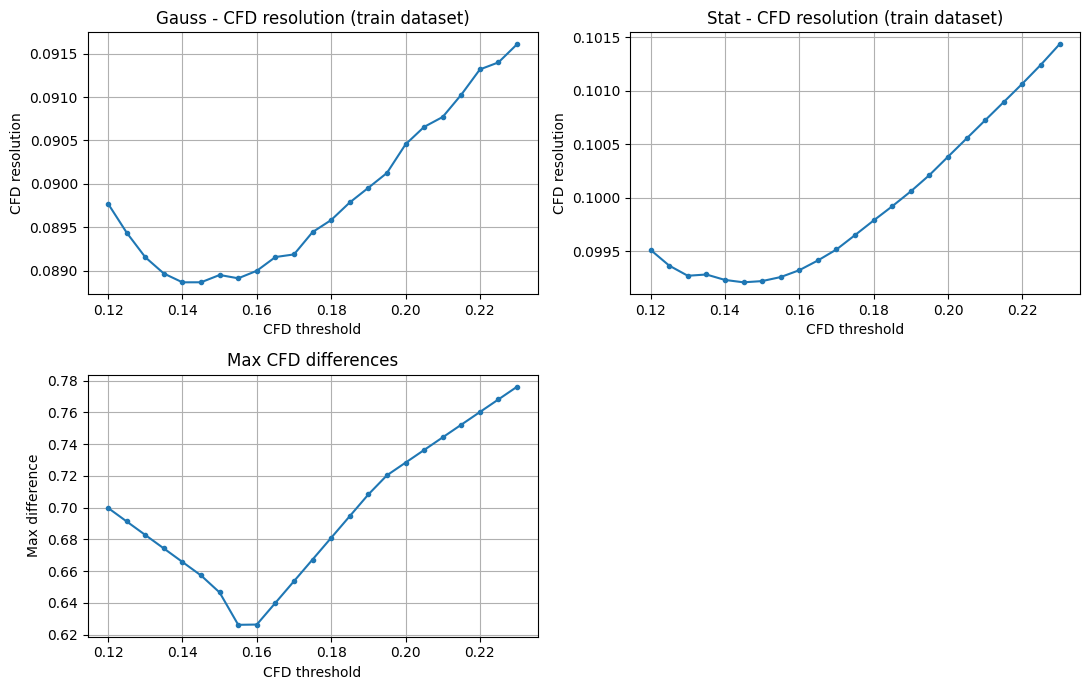

Optimal CFD threshold: 0.145


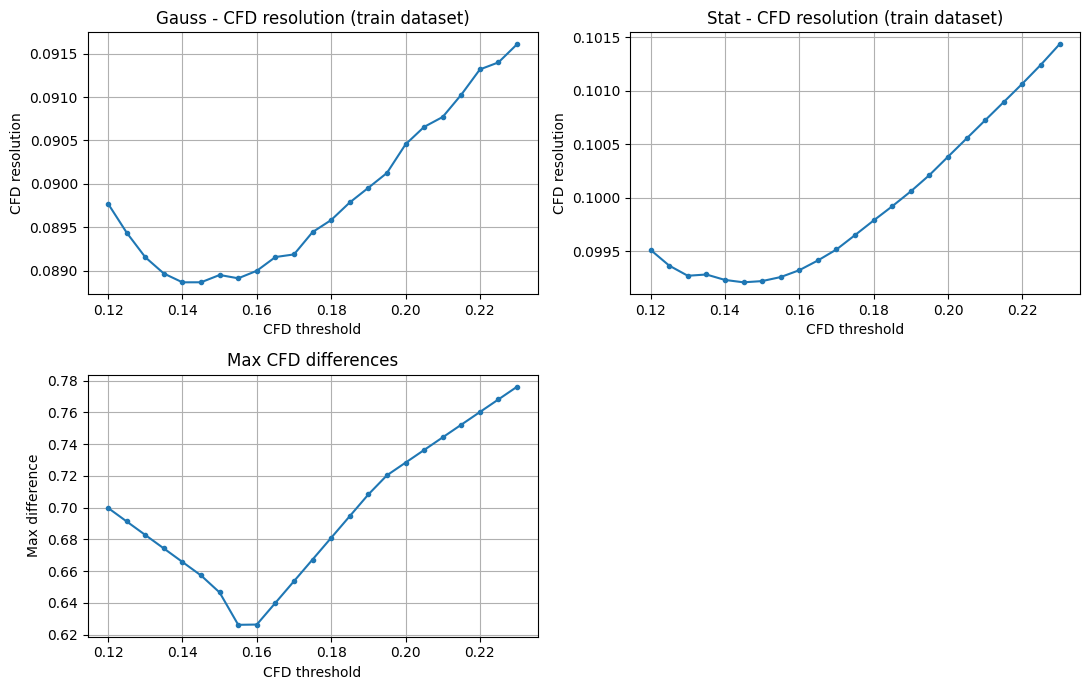

Optimal CFD threshold: 0.145


In [24]:
thresholds = np.arange(0.12, 0.23, 0.005)
optimal_cfd_threshold = find_optimal_cfd_threshold(thresholds, N_BASELINE, X_train, y_train_t, X_TIME, n_jobs=16)

In [25]:
cfd = CFD(n_baseline=N_BASELINE, threshold=optimal_cfd_threshold)

y_pred_t = cfd.predict(X_TIME, X_test)

y_pred_t_cfd = np.copy(y_pred_t)

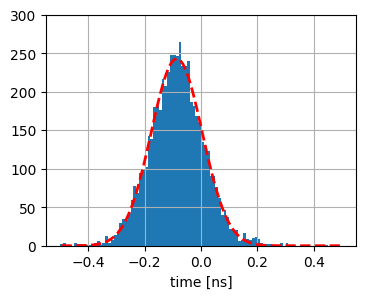

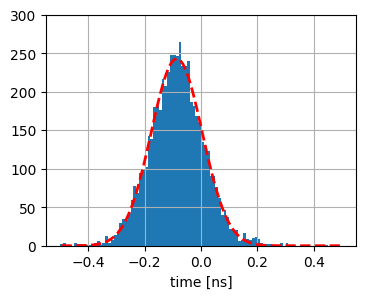

In [26]:
plt.figure(figsize=(4, 3))
mu_cfd, std_cfd_hist, pcov, fwhm_cfd = plot_difference_hist(y_test_t, y_pred_t, print_pcov=PRINT_PCOV, show=False, close=False, return_mu=True)

plt.title(None)
plt.ylim(top=300)
plt.grid()
save_plt(IMAGES_PATH + '/cfd_diff.pdf')

std_cfd_stat = np.std(y_pred_t - y_test_t)

# Optimal model

In [27]:
model = optimal_model_builder_ch_2_11()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 24)]         0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 24)          96          ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 reshape (Reshape)              (None, 24, 1)        0           ['batch_normalization[0][0]']    
                                                                                                  
 conv1d (Conv1D)                (None, 24, 8)        24          ['reshape[0][0]']            

In [28]:
history = train_model(model, "optimal", y_train=y_train, y_val=y_test, train=False)

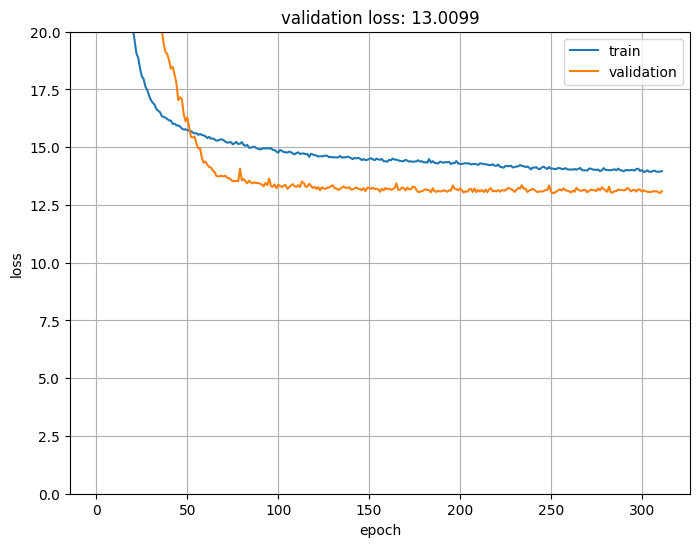

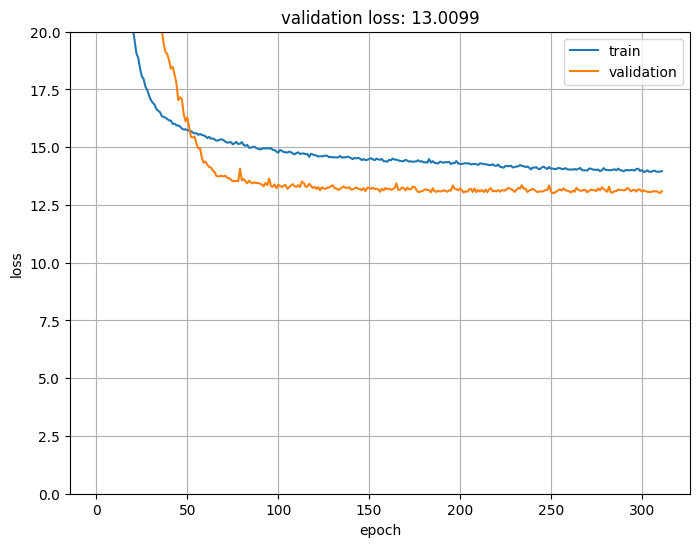

In [29]:
plot_history(history, ymax=20)

176/176 [==============================] - 2s 2ms/step


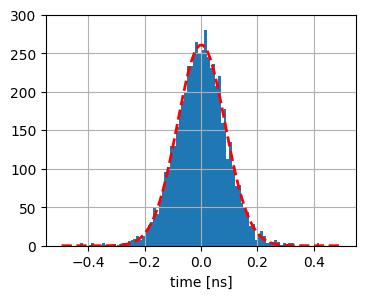

176/176 [==============================] - 1s 3ms/step


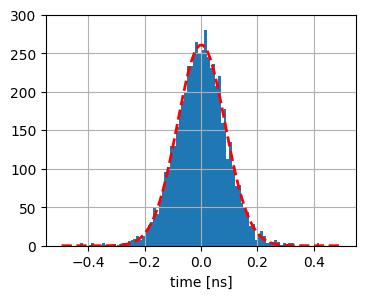

In [30]:
# MLP/CNN
# y_pred_t = model.predict(X_test)[:, 0]

# UNet
y_pred = model.predict(X_test)
y_pred_t = np.empty(y_pred.shape[0])
for i, y in enumerate(y_pred):
    _, y_pred_t[i], _, _ = get_gauss_stats(X_TIME, y, a_0=1, std_0=1. * TIME_STEP)

y_pred_t_model = np.copy(y_pred_t)

# Calculate std
plt.figure(figsize=(4, 3))
mu_model, std_hist_model, pcov, fwhm_model = plot_difference_hist(y_test_t, y_pred_t, print_pcov=PRINT_PCOV, show=False, close=False, return_mu=True)

plt.ylim(top=300)
plt.grid()
save_plt(IMAGES_PATH + '/model_diff.pdf')

std_stat_model = np.std(y_pred_t - y_test_t)

# Compare standard deviations

### Difference histogram – Gauss

In [31]:
compare_results([std_hist_model], ["Optimal NN model"], std_cfd_hist)

       CFD: 90.39 ps
Optimal NN model: 84.74 ps (improvement: 6.25 %)
       CFD: 90.39 ps
Optimal NN model: 84.74 ps (improvement: 6.25 %)


### Stat

In [32]:
compare_results([std_stat_model], ["Optimal NN model"], std_cfd_stat)

       CFD: 99.28 ps
Optimal NN model: 91.83 ps (improvement: 7.50 %)
       CFD: 99.28 ps
Optimal NN model: 91.83 ps (improvement: 7.50 %)


# Diff histograms

## CFD

In [33]:
timestamps_diff = y_pred_t_cfd - y_test_t
hist_data = plt.hist(timestamps_diff, bins=100, range=(-0.5, 0.5))

# retrieve bins
bins_x, bins_y = hist_data[1][:-1], hist_data[0]
x_step = (bins_x[1] - bins_x[0]) / 2
bins_x += x_step

a_cfd, mean_cfd, std_cfd, _ = get_gauss_stats(bins_x, bins_y)
plt.close()

## Model

In [34]:
timestamps_diff = y_pred_t_model - y_test_t
hist_data = plt.hist(timestamps_diff, bins=100, range=(-0.5, 0.5))

# retrieve bins
bins_x, bins_y = hist_data[1][:-1], hist_data[0]
x_step = (bins_x[1] - bins_x[0]) / 2
bins_x += x_step

a_model, mean_model, std_model, _ = get_gauss_stats(bins_x, bins_y)
plt.close()

## CFD: plot

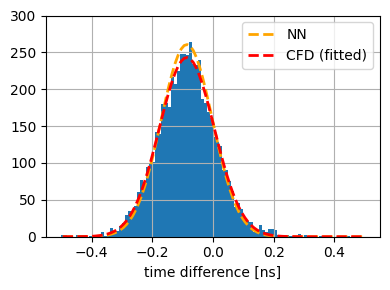

In [42]:
plt.figure(figsize=(4, 3))

timestamps_diff = y_pred_t_cfd - y_test_t
hist_data = plt.hist(timestamps_diff, bins=100, range=(-0.5, 0.5))

# retrieve bins
bins_x, bins_y = hist_data[1][:-1], hist_data[0]
x_step = (bins_x[1] - bins_x[0]) / 2
bins_x += x_step

gauss_y = norm.pdf(bins_x, mean_cfd, std_model)
gauss_y *= a_model / np.max(gauss_y)
plt.plot(bins_x, gauss_y, '--', linewidth=2, label='NN', color='orange')

gauss_y = norm.pdf(bins_x, mean_cfd, std_cfd)
gauss_y *= a_cfd / np.max(gauss_y)
plt.plot(bins_x, gauss_y, '--', linewidth=2, label='CFD (fitted)', color='red')

plt.xlabel('time difference [ns]')
plt.grid()
plt.ylim(top=300)
plt.legend()

plt.tight_layout()
save_plt(IMAGES_PATH + "/cfd_with_model_diff.pdf")

plt.show()

## Model: plot

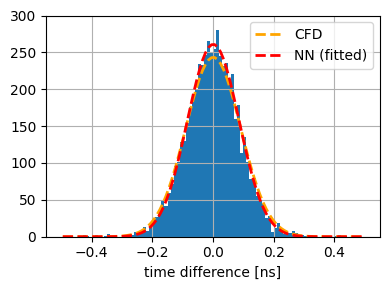

In [43]:
plt.figure(figsize=(4, 3))

timestamps_diff = y_pred_t_model - y_test_t
hist_data = plt.hist(timestamps_diff, bins=100, range=(-0.5, 0.5))

# retrieve bins
bins_x, bins_y = hist_data[1][:-1], hist_data[0]
x_step = (bins_x[1] - bins_x[0]) / 2
bins_x += x_step

gauss_y = norm.pdf(bins_x, mean_model, std_cfd)
gauss_y *= a_cfd / np.max(gauss_y)
plt.plot(bins_x, gauss_y, '--', linewidth=2, label='CFD', color='orange')

gauss_y = norm.pdf(bins_x, mean_model, std_model)
gauss_y *= a_model / np.max(gauss_y)
plt.plot(bins_x, gauss_y, '--', linewidth=2, label='NN (fitted)', color='red')

plt.xlabel('time difference [ns]')
plt.grid()
plt.ylim(top=300)
plt.legend()

plt.tight_layout()
save_plt(IMAGES_PATH + "/model_with_cfd_diff.pdf")

plt.show()